In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os.path

%matplotlib inline

# Physical constants

In [12]:
q0 = 1.6e-19 # electron charge in Coulomb
eV = 1.6e-19 # electron volt in Jouls

# Give the input directories as a list

In [13]:
directories = list()

directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_5_nm_bids_1.5_thick"))
directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_10_nm_bids_1.5_thick"))
directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_15_nm_bids_1.5_thick"))
directories.append(os.path.expanduser("~/research/monte_carlo_davoody_realistic_20_nm_bids_1.5_thick"))

# read the current data

steady state drain current: 2.14e+28
steady state drain current: 2.32e+27
steady state drain current: 4.49e+26
steady state drain current: 2.84e+26


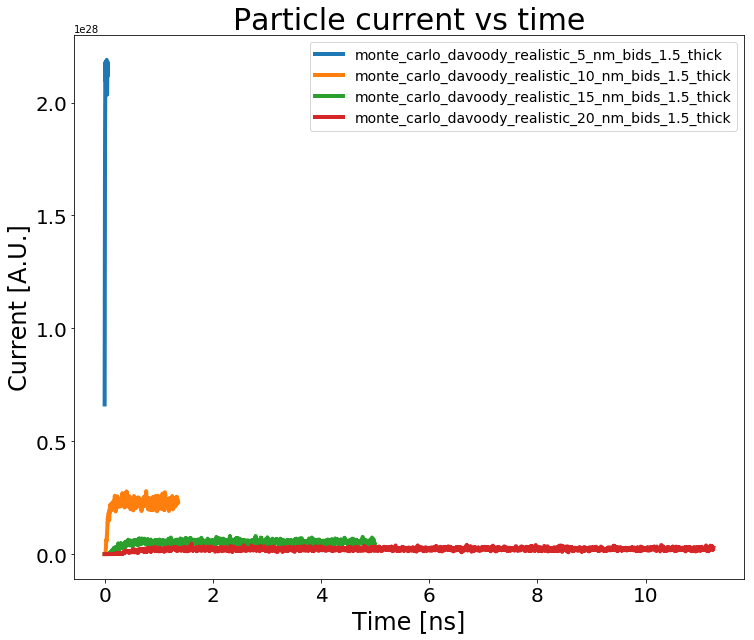

In [14]:
def plot_current(directory, box_size=10, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "region_current.dat")
    current = np.loadtxt(filename)
    time = current[:,0]
    current = current[:,1:]
    
    assert (current.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_current = np.zeros((current.shape[0]-box.shape[0]+1,current.shape[1]))
    for i in range(0,current.shape[1]):
        smooth_current[:,i] = np.convolve(current[:,i], box, mode='valid')/np.sum(box)
        
    print("steady state drain current: {:.2e}".format(smooth_current[-1,2]))
    steady_current = smooth_current[-1,2]
        
    ax.plot(time[:smooth_current.shape[0]]*1.e9,(smooth_current[:,2]), linewidth=4, color=color)
    ax.set_title("Particle current vs time",fontsize=30)
    ax.set_xlabel("Time [ns]",fontsize=24)
    ax.set_ylabel("Current [A.U.]",fontsize=24)
    ax.tick_params(labelsize=20)
    return steady_current


current = np.array([])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
legends = []
for d in directories:
    c = plot_current(d, ax=ax)
    current = np.append(current,c)
    legends.append(os.path.basename(d))
_ = ax.legend(legends, fontsize=14)
# ax.set_xlim([0,0.1])


# Population profile versus time

length of population array: 69


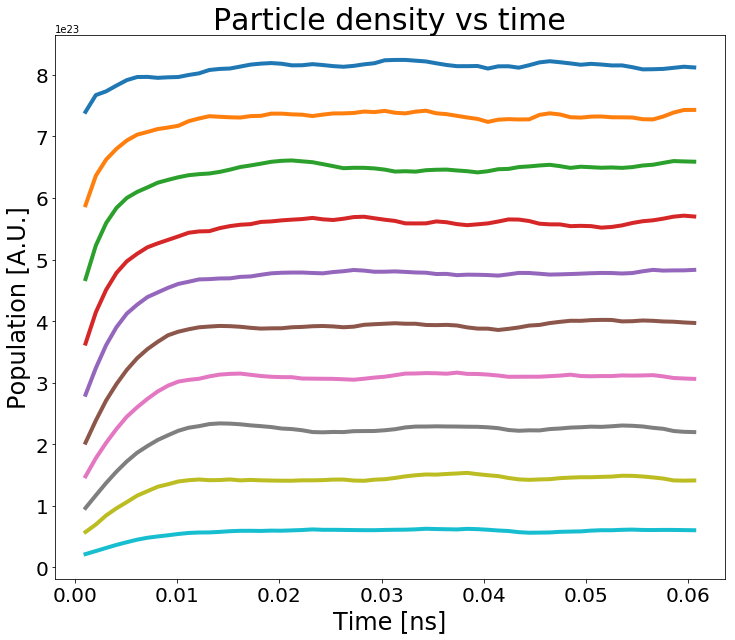

In [15]:
def plot_population_vs_time(directory, box_size=10, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "population_profile.dat")
    population = np.loadtxt(filename)
    distance = population[0,1:]
    time = population[1:,0]
    population = population[1:,1:]
    print("length of population array: {}".format(population.shape[0]))
    
    assert (population.shape[0] > box_size), "box_size must be smaller than the number of time steps: {}".format(current.shape[0])

    # calculate and plot box average of the data
    box = np.ones(box_size)
    smooth_population = np.zeros((population.shape[0]-box.shape[0]+1,population.shape[1]))
    for i in range(0,population.shape[1]):
        smooth_population[:,i] = np.convolve(population[:,i], box, mode='valid')/np.sum(box)
        
    ax.plot(time[:smooth_population.shape[0]]*1.e9,(smooth_population[:,:]), linewidth=4, color=color)
    _ = ax.set_title("Particle density vs time",fontsize=30)
    _ = ax.set_xlabel("Time [ns]",fontsize=24)
    _ = ax.set_ylabel("Population [A.U.]",fontsize=24)
    _ = ax.tick_params(labelsize=20)
    return ax

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
_ = plot_population_vs_time(directories[0],ax=ax)

# Population profile versus position

length of population array: 69
time: 40.4
dn/dx = 8.68e+29

length of population array: 1352
time: 688.315
dn/dx = 2.35e+29

length of population array: 4948
time: 2504.2949999999996
dn/dx = 9.52e+28

length of population array: 11149
time: 5635.800000000001
dn/dx = 6.02e+28



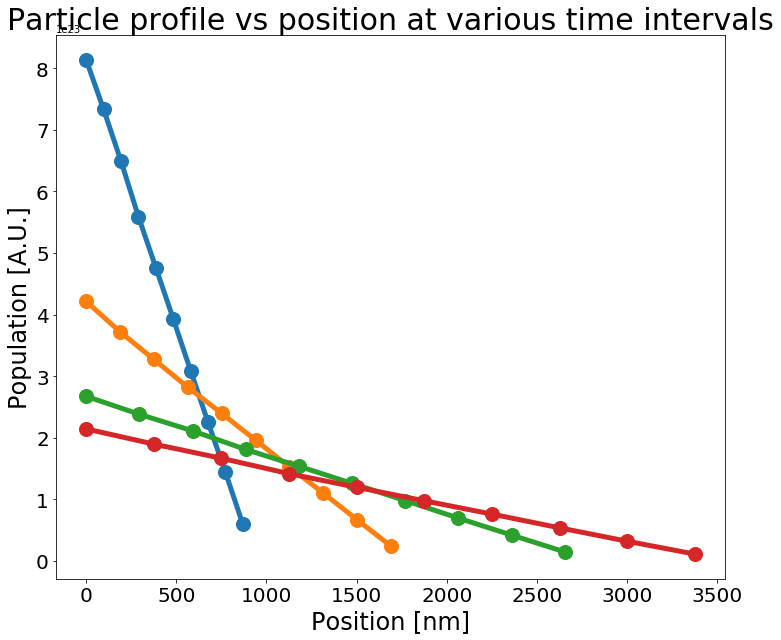

In [16]:
def plot_population_vs_position(directory, start=0, end=None, color=None, ax=None):
    if (ax is None):
        fig = plt.figure(figsize=(12,10))
        ax = fig.add_subplot(1,1,1)
    filename = os.path.join(directory, "population_profile.dat")
    population = np.loadtxt(filename)
    distance = population[0,1:]
    time = population[1:,0]
    population = population[1:,1:]
    print("length of population array: {}".format(population.shape[0]))
    
    if (end is None):
        end = population.shape[0]
    
    assert (population.shape[0] > start), "start interval must be smaller than the number of time steps: {}".format(population.shape[0])
    avg_population = np.mean(population[start:end,:],0)
        
    ax.plot(distance*1.e9, avg_population, linewidth=5, marker='o', markersize=14, color=color)
    ax.set_title("Particle profile vs position",fontsize=30)
    ax.set_xlabel("Position [nm]",fontsize=24)
    ax.set_ylabel("Population [A.U.]",fontsize=24)
    ax.tick_params(labelsize=20)
    print("time: {}".format(np.mean(time[start:end])*1.e12))
    density_gradient = abs((avg_population[0]-avg_population[-1])/(distance[0]-distance[-1]))
    print("dn/dx = {:0.2e}\n".format(density_gradient))
    return density_gradient

density_gradient = np.array([])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
for d in directories:
    grad = plot_population_vs_position(d, start=10,end=None,ax=ax)
    density_gradient = np.append(density_gradient,grad)

_ = ax.set_title("Particle profile vs position at various time intervals",fontsize=30)

# Calculate diffusion coefficient
$$ D = J/\big(\frac{dn}{dx}\big) $$
has units of [$\text{m}^2/\text{s}$]

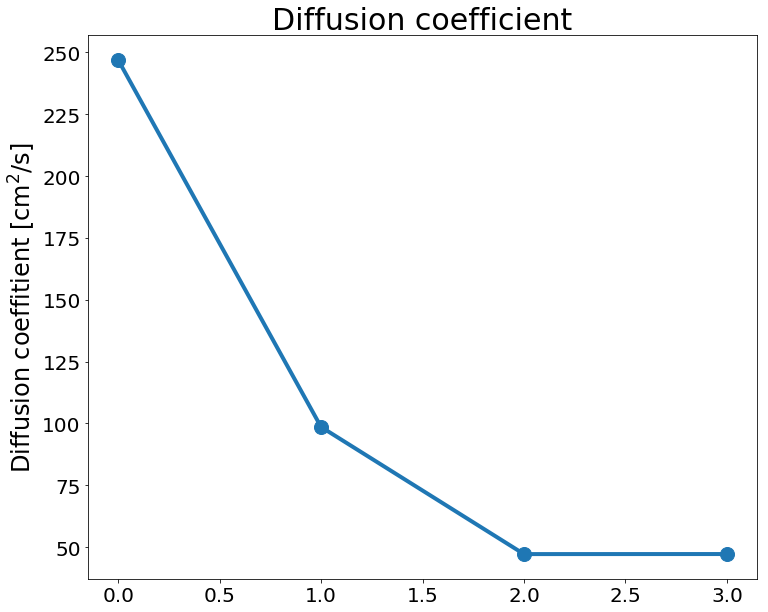

In [19]:
diff_coef = np.divide(current,density_gradient)
x_axis = np.array(range(len(diff_coef)))

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.plot(x_axis, diff_coef*1.e4, linewidth=4, marker='o', markersize='14')

ax.set_title("Diffusion coefficient", fontsize=30)
ax.set_ylabel("Diffusion coeffitient [cm$^2$/s]",fontsize=24)
ax.tick_params(labelsize=20)